In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import scipy
import scipy.integrate as integrate
from scipy.special import gamma, factorial
from scipy.integrate import quad
from scipy.stats import poisson

In [2]:
def k_rational(x, a=-14):
    return x/(x+a)


def k_exp(x, a=-14, alpha=1 ):
    return 1-alpha*np.exp(np.abs(x)/a)

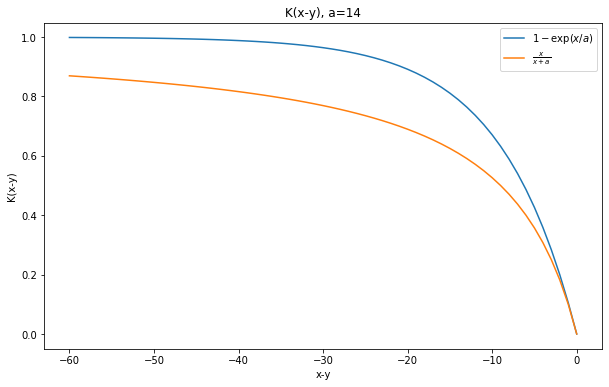

In [3]:
a=-9

aend = -60
x = np.linspace(aend, 0, abs(aend)+1)

Kexp = k_exp(x, a)
Krat = k_rational(x, a)

plt.figure(figsize=(10, 6))

plt.plot(x, Kexp, label = r"$1 -\exp(x/a)$")
plt.plot(x, Krat, label = r"$\frac{x}{x+a}$")

plt.ylabel("K(x-y)")
plt.xlabel("x-y")

plt.title("K(x-y), a=14")
plt.legend(loc="best")


In [4]:
def GetAntigeneticMatrix(n_shtamms):

    mn = np.linspace(-n_shtamms+1, 0 , n_shtamms, dtype = int)
 
 
    K = []

    for i in range(len(mn)):
        k_temp = []
        for j in range(len(mn)):
            if (j>i):
                k_temp.append(k_rational(i-j))
            elif (j==i):
                k_temp.append(0)
            else:
                k_temp.append(0)

        K.append(k_temp)

    K=np.array(K)
 
    K += 0.
    
    return K

Text(0, 0.5, 'x - new ')

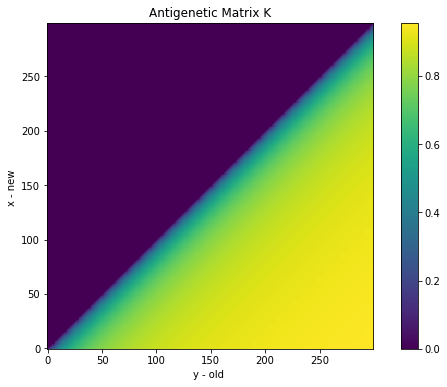

In [5]:
n_shtamms = 300
K = GetAntigeneticMatrix(n_shtamms)


plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, n_shtamms, 50))

plt.imshow(K,  origin = 'lower')

plt.colorbar()
 
plt.title("Antigenetic Matrix K")

plt.xlabel("y - old ")
plt.ylabel("x - new ")

In [6]:
def GetIntialVectors(n_shtamms=300):
    N_populations = (n_shtamms) * 1000000

    r0 = np.zeros((1, n_shtamms)).T
    i0 = np.zeros((1, n_shtamms)).T
 

    r0[:20] = 0.999*N_populations/20 


    i_all = 0.001 * N_populations  
    ic = i_all

    i0[20] = i_all 

    return i0/N_populations, r0/N_populations, N_populations

In [7]:

U_b = 0.0058

def mutations_move(infected, N_populations=-1 ):
    
    if(N_populations==-1):
        N_populations = 1000000*len(infected)
    
    new_infections = np.zeros(len(infected)-1)
    for i in range(len(infected)):
        if (infected[i]!=0 ):
            
            if(infected[i]<0):
                continue 
                
            mean_moves = U_b * infected[i] * N_populations
            
            r = poisson.rvs(mean_moves) #распределение Пуассона 
            
            new_infections[i] = r #r - число, которое пойдет в следующий (передний) бин 
            
    return new_infections/N_populations

def change_infected(i_current, i_mutated):
    """i_mutated короче на один"""
    
    for i in range(len(i_mutated)):
        if(i_mutated[i]!=0):
            i_current[i] = i_current[i] - i_mutated[i]
            i_current[i+1] = i_current[i+1] + i_mutated[i]
 
        

1.0


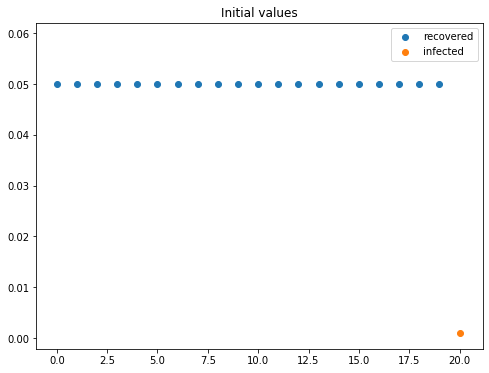

In [8]:
n_shtamms = 100
K = GetAntigeneticMatrix(n_shtamms)
i0, r0, N_populations = GetIntialVectors(n_shtamms )

r0_show = r0.copy()
r0_show [r0_show ==0 ] = np.nan

i0_show = i0.copy()
i0_show [i0_show ==0 ] = np.nan


plt.figure(figsize=(8, 6))

plt.scatter(np.arange(0, n_shtamms, 1), r0_show, label = "recovered")
plt.scatter(np.arange(0, n_shtamms, 1), i0_show, label = "infected")

plt.title("Initial values")

plt.legend()

print(np.sum(r0) + np.sum(i0))

IndexError: index 99 is out of bounds for axis 0 with size 99

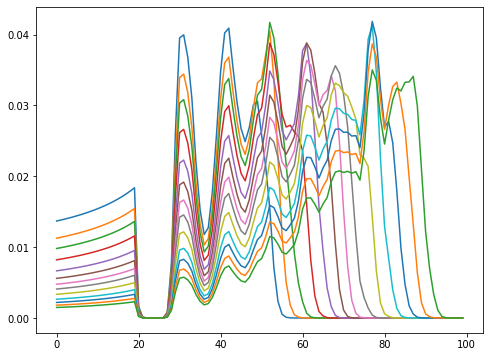

In [14]:
plt.figure(figsize=(8, 6))

nsteps = 900
h = 0.5 #time step 

r_initial = r0.copy()
i_initial = i0.copy()

r_time = [np.sum(r0)]
i_time = [np.sum(i0)]

r_all_time = r0
i_all_time = i0

R0 = 2.0

for i in range(nsteps):
    
    
    P = np.dot(K, i0)
    #print(P)
    Q = np.dot(K.T, r0)
    #print(Q)
    r1 = r0*(1-h*R0*P) +h*i0
    i1 = i0*(1+h*R0*Q-h)
    
    #print(i, np.sum(r1<0),end = " ")
    #print(i, np.sum(i1<0) )
    
    #print(r1)
    i_moves = mutations_move(i1)
    change_infected(i1, i_moves)
    
    #i1 = i1 * (i1 > 1/N_populations)
    #if(i==3):
        #print(i1)
        #print(r1)
        #print(np.sum(r0) + np.sum(i0) - N_populations)
        #break 
        
        
    if(i%50==0):
        plt.plot(r1)
    
    r0 = r1.copy()
    i0 = i1.copy()
    
    r_time.append(np.sum(r0) )
    i_time.append(np.sum(i0))
    
    r_all_time = np.hstack((r_all_time, r0))
    i_all_time = np.hstack((i_all_time, i0))
    #print(np.sum(r0) + np.sum(i0) )
    #print(np.dot(Q[:,0], i0[:,0]))
    
plt.ylabel("Recovered fraction ")
    

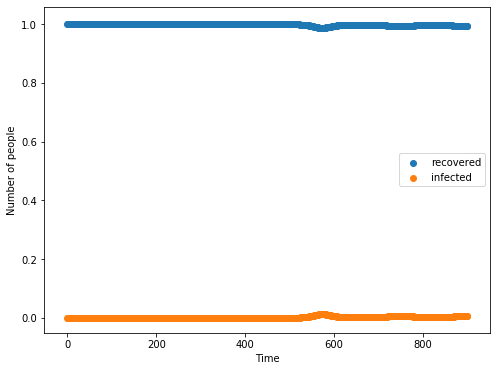

In [10]:
plt.figure(figsize=(8, 6))

plt.scatter(np.arange(len(r_time)), r_time, label = "recovered")
plt.scatter(np.arange(len(i_time)),i_time, label = "infected")

plt.xlabel("Time")
plt.ylabel("Number of people")
plt.legend()

0.9999999999999997


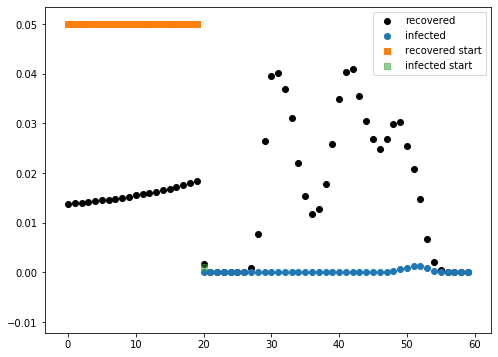

In [11]:
r_initial1=r_initial
r_initial1[r_initial1==0] = np.nan
i_initial1=i_initial
i_initial1[i_initial1==0] = np.nan

r0_show = r1.copy()
r0_show [r0_show ==0 ] = np.nan

i0_show = i1.copy()
i0_show [i0_show ==0 ] = np.nan


plt.figure(figsize=(8, 6))

plt.scatter(np.arange(0, n_shtamms, 1), r0_show, label = "recovered", c= "k")
plt.scatter(np.arange(0, n_shtamms, 1), i0_show, label = "infected")

plt.scatter(np.arange(0, n_shtamms, 1), r_initial1, marker = "s", label = "recovered start")
plt.scatter(np.arange(0, n_shtamms, 1), i_initial1, marker = "s", label = "infected start", alpha = 0.5)

#plt.title("Initial values")

plt.legend()

print(np.sum(r0) + np.sum(i0))


Text(0, 0.5, ' dx ')

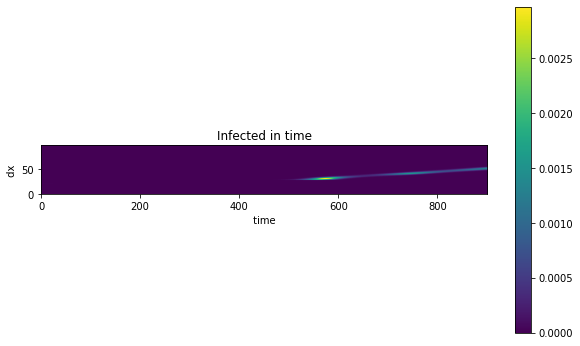

In [12]:

plt.figure(figsize=(10, 6))


#r_all_time[r_all_time==0] = np.nan

plt.imshow(i_all_time,  origin = 'lower')

plt.colorbar()
 
plt.title("Infected in time")

plt.xlabel(" time ")
plt.ylabel(" dx ")

Text(0, 0.5, ' dx ')

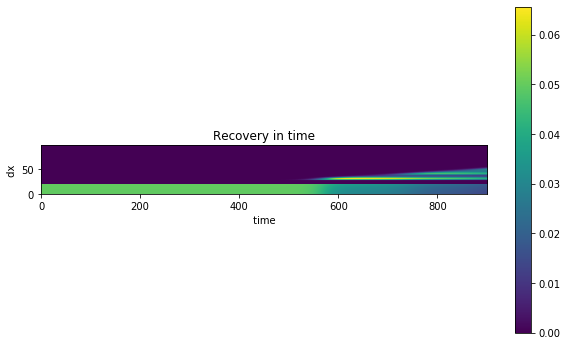

In [13]:

plt.figure(figsize=(10, 6))


#r_all_time[r_all_time==0] = np.nan

plt.imshow(r_all_time,  origin = 'lower')

plt.colorbar()
 
plt.title("Recovery in time")

plt.xlabel(" time ")
plt.ylabel(" dx ")